The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

**As an optional challenge** Once you have a working pipeline for vehicle detection, add in your lane-finding algorithm from the last project to do simultaneous lane-finding and vehicle detection!

**If you're feeling ambitious** (also totally optional though), don't stop there!  We encourage you to go out and take video of your own, and show us how you would implement this project on a new video!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label

from skimage.feature import hog
import glob
import time

%matplotlib inline

In [2]:
# from lesson_functions.py
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [3]:

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler=None, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        #test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    



In [4]:
# also from lesson materials
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Time to write my own code!

This part is divided into:

1.  Writing our own classifier
2.  Find boxes

In [5]:
# Read in cars and notcars
"""
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
"""

cars = glob.glob('largeset/vehicles/*/*.png')+glob.glob('smallset/vehicles_smallset/*.jpeg')
notcars = glob.glob('largeset/non-vehicles/*/*.png')+glob.glob('./smallset/non-vehicles_smallset/*.jpeg')

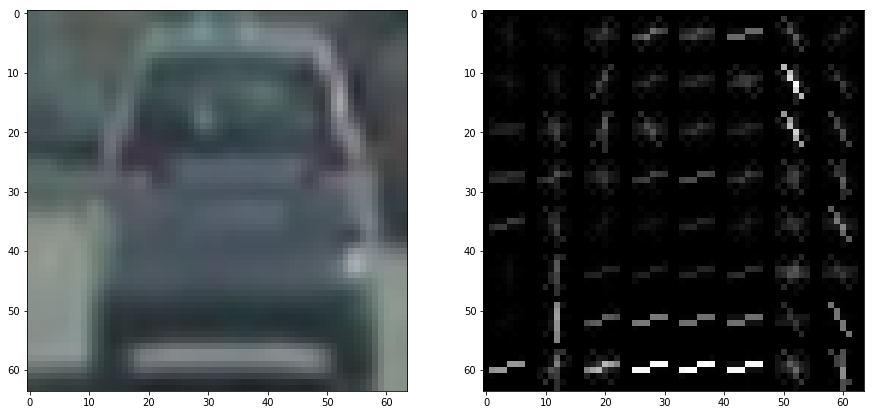

In [6]:
# lets see what the hog features look like...

car1 = mpimg.imread(cars[5])
_, car2 = get_hog_features(cv2.cvtColor(car1, cv2.COLOR_RGB2GRAY)
, 9, 8, 8, vis=True, feature_vec=True)
_, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7))
ax1.imshow(car1)
ax2.imshow(car2, cmap='gray')

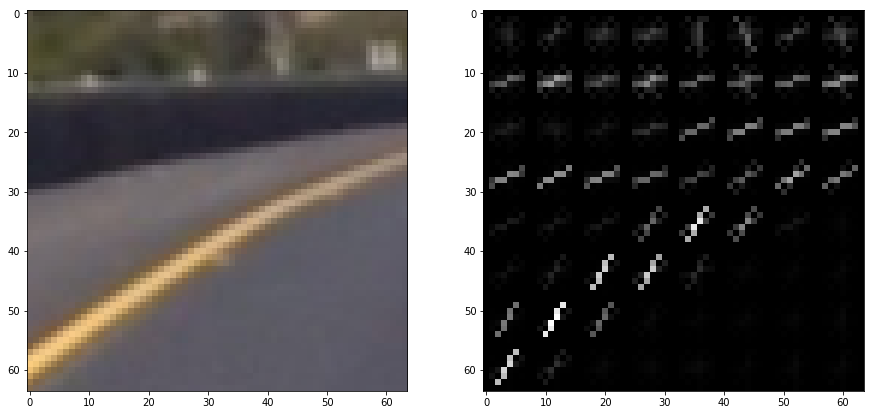

In [7]:
ncar1 = mpimg.imread(notcars[5])
_, ncar2 = get_hog_features(cv2.cvtColor(ncar1, cv2.COLOR_RGB2GRAY), 9, 8, 8, vis=True, feature_vec=True)
_, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7))
ax1.imshow(ncar1)
ax2.imshow(ncar2, cmap='gray')

In [8]:
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

car_imgs = [mpimg.imread(x) for x in cars]
notcar_imgs = [mpimg.imread(x) for x in notcars]

In [9]:
X = np.vstack((car_imgs, notcar_imgs)).astype(np.float64)
y = np.zeros(len(car_imgs)+len(notcar_imgs))
y[:len(car_imgs)] = 1

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

In [11]:
X_train.shape

(10040, 64, 64, 3)

In [12]:
# change the extract_features to a scikit learn compatible pipeline
class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
        self.color_space  = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        return [single_img_features(single_x, self.color_space, self.spatial_size, self.hist_bins, 
                                   self.orient, self.pix_per_cell, 
                                   self.cell_per_block, self.hog_channel, self.spatial_feat, 
                                   self.hist_feat, self.hog_feat)
                for single_x in X]

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

In [14]:
# Use a linear SVC 
model = Pipeline([
    ('feats', FeatureUnion([('create_feats', FeatureCreator())])), 
    ('scaler', StandardScaler()),
    ('linear svm', SGDClassifier(penalty='elasticnet', random_state=42))])
#model = Pipeline([
#    ('feats', FeatureUnion([('create_feats', FeatureCreator())])), 
#    ('scaler', StandardScaler()),
#    ('linear svm', GradientBoostingClassifier())])
model.fit(X_train, y_train)

Pipeline(steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('create_feats', FeatureCreator(cell_per_block=2, color_space='RGB', hist_bins=32,
        hist_feat=True, hog_channel=0, hog_feat=True, orient=9,
        pix_per_cell=8, spatial_feat=True, spatial_size=(32, 32)))],
       transformer_...alty='elasticnet', power_t=0.5, random_state=42, shuffle=True,
       verbose=0, warm_start=False))])

In [15]:
yhat_train = model.predict(X_train)
metric = accuracy_score(y_train, yhat_train)
print("Accuracy Train Rate: {}".format(metric))

Accuracy Train Rate: 0.9542828685258964


In [16]:
yhat_test = model.predict(X_test)
metric = accuracy_score(y_test, yhat_test)
print("Accuracy Test Rate: {}".format(metric))

Accuracy Test Rate: 0.9360621452046609


In [17]:
# we can use a feature search in scikit learn to determine a good configuration...
# we can do this later

Find cars in a box...

Goal: make a bunch of rectangles and return all rectangles which look like a car. 

In [18]:
def search_windows_pipeline(img, windows, model):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # feed into pipeline
        prediction = model.predict([test_img])
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

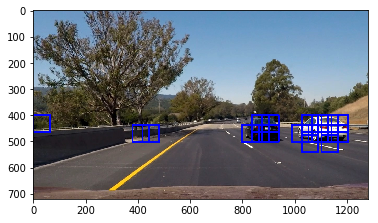

In [19]:
image = mpimg.imread("test_images/test6.jpg")
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                    xy_window=(64, 64), xy_overlap=(0.4, 0.4))

hot_windows = search_windows_pipeline(image, windows, model)  
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

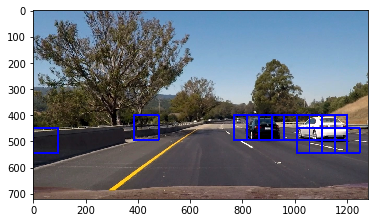

In [20]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows_pipeline(image, windows, model)  
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

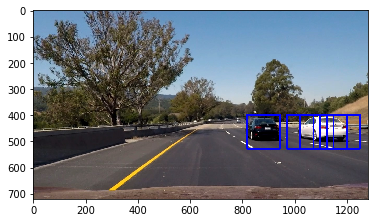

In [21]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                    xy_window=(128, 128), xy_overlap=(0.6, 0.6))

hot_windows = search_windows_pipeline(image, windows, model)  
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

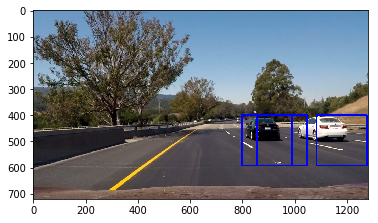

In [22]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 720], 
                    xy_window=(192, 192), xy_overlap=(0.7, 0.7))

hot_windows = search_windows_pipeline(image, windows, model)  
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

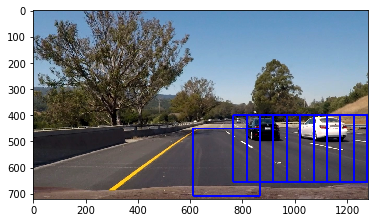

In [23]:
# this one suggests we need to have some limits on x start stop!
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 720], 
                    xy_window=(256, 256), xy_overlap=(0.8, 0.8))

hot_windows = search_windows_pipeline(image, windows, model)  
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

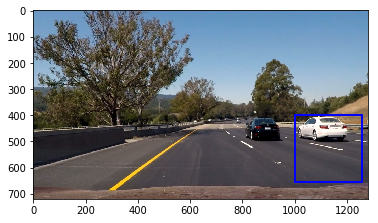

In [24]:
# Adding limits here appears to solve it - the idea is that a car that is close to you shouldn't be in the same "lane" 
# otherwise it might mean you're about to crash! - also it is clear that it is 
# picking up the very bottom of the black car - which might trigger a higher incidence
# of false positives
windows = (slide_window(image, x_start_stop=[1000, None], y_start_stop=[400, 720], 
                        xy_window=(256, 256), xy_overlap=(0.8, 0.8)) +
              slide_window(image, x_start_stop=[0, 280], y_start_stop=[400, 720], 
                        xy_window=(256, 256), xy_overlap=(0.8, 0.8)))

hot_windows = search_windows_pipeline(image, windows, model)  
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

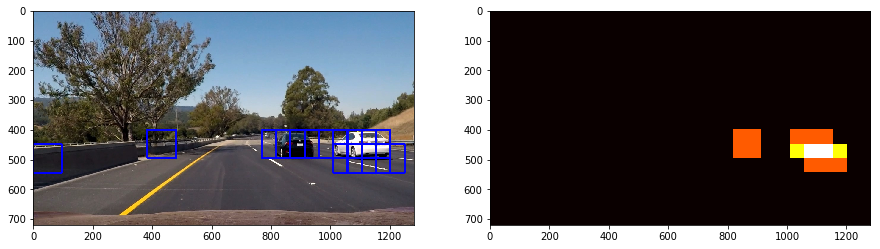

In [25]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows_pipeline(image, windows, model)  
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

# lets draw head boxes...
heat = np.zeros_like(image[:,:,0])
heat = add_heat(heat, hot_windows)    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

_, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7))
ax1.imshow(window_img)
ax2.imshow(heatmap, cmap='hot')

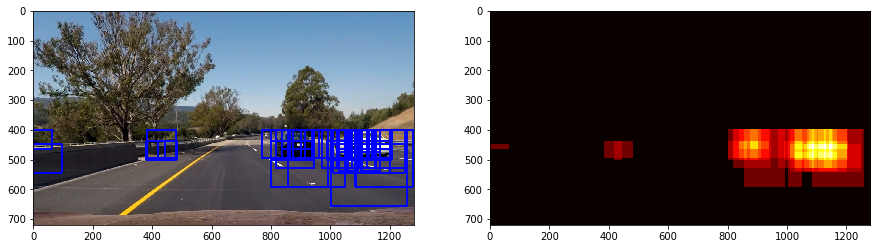

In [26]:
# combine all windows and draw the head map
windows = (slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                        xy_window=(64, 64), xy_overlap=(0.4, 0.4)) +
              slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5)) +
              slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                        xy_window=(128, 128), xy_overlap=(0.6, 0.6)) +
              slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 720], 
                        xy_window=(192, 192), xy_overlap=(0.7, 0.7)) +
              slide_window(image, x_start_stop=[1000, None], y_start_stop=[400, 720], 
                        xy_window=(256, 256), xy_overlap=(0.8, 0.8)) +
              slide_window(image, x_start_stop=[0, 280], y_start_stop=[400, 720], 
                        xy_window=(256, 256), xy_overlap=(0.8, 0.8)))

hot_windows = search_windows_pipeline(image, windows, model)  
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

# lets draw head boxes...
heat = np.zeros_like(image[:,:,0])
heat = add_heat(heat, hot_windows)    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

_, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7))
ax1.imshow(window_img)
ax2.imshow(heatmap, cmap='hot')

2 cars found


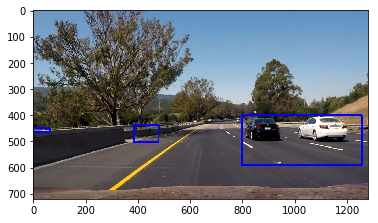

In [27]:
# apply the label as suggested...
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
print("{} cars found".format(len(labels)))
plt.imshow(draw_img)

Run a full pipeline!

In [28]:
def process_image(image, model=model):
    # process everything based on the model pipeline used above
    windows = (slide_window(image, x_start_stop=[300, 980], y_start_stop=[350, 550], 
                            xy_window=(64, 64), xy_overlap=(0.0, 0.0)) +
                  slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                            xy_window=(96, 96), xy_overlap=(0.5, 0.5)) +
                  slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600], 
                            xy_window=(128, 128), xy_overlap=(0.5, 0.5)) +
                  #slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 720], 
                  #          xy_window=(192, 192), xy_overlap=(0.7, 0.7)) +
                  slide_window(image, x_start_stop=[1000, None], y_start_stop=[400, 720], 
                            xy_window=(256, 256), xy_overlap=(0.9, 0.9)) +
                  slide_window(image, x_start_stop=[0, 280], y_start_stop=[400, 720], 
                            xy_window=(256, 256), xy_overlap=(0.9, 0.9)))

    hot_windows = search_windows_pipeline(image, windows, model)  
    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

    # lets draw head boxes...
    heat = np.zeros_like(image[:,:,0])
    heat = add_heat(heat, hot_windows)    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)    
    return draw_img

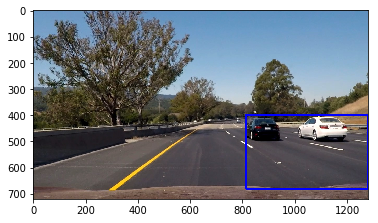

In [29]:
plt.imshow(process_image(image, model))

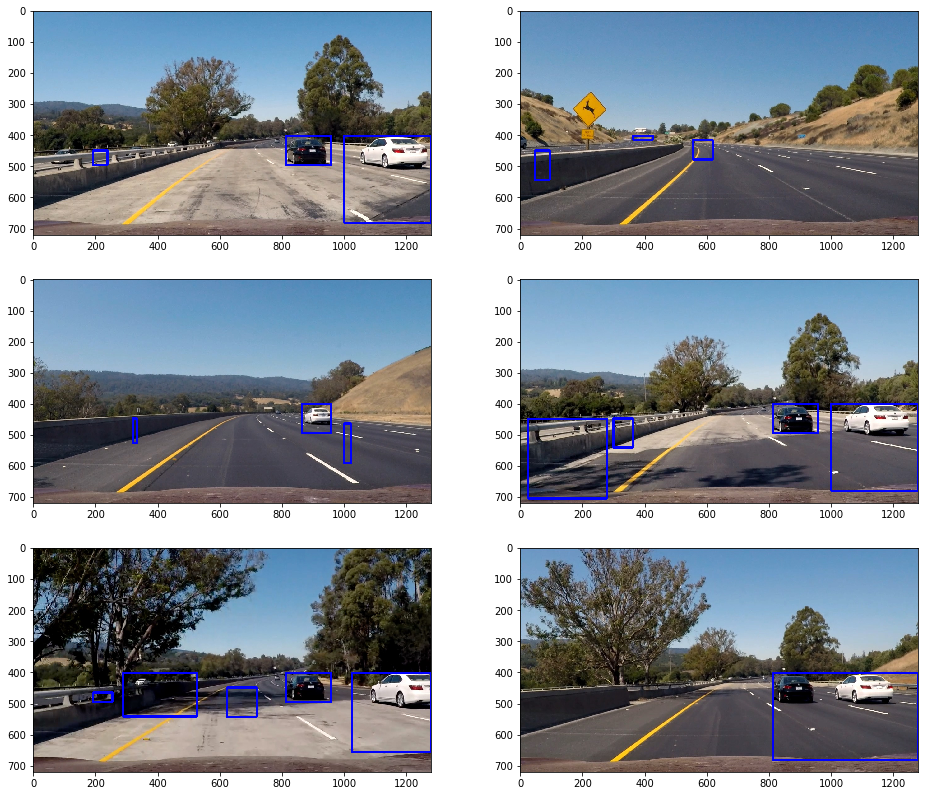

In [30]:
# run for all images in test
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_image(mpimg.imread(im)))

In [ ]:
test_out_file = 'test_video_20170813.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_20170813.mp4
[MoviePy] Writing video test_video_20170813.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:19<00:00,  1.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_20170813.mp4 

Wall time: 21.6 s


In [ ]:
test_out_file = 'project_video_20170813.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_20170813.mp4
[MoviePy] Writing video project_video_20170813.mp4


  5%|████▍                                                                           | 69/1261 [00:37<10:33,  1.88it/s]